In [1]:
import pandas as pd
from backend.src.models.feature_provider import FeatureProvider
from backend.src.utils.logging_handler import setup_logging
from backend.src.utils.config import Config

config = Config("../config.yaml")
setup_logging()

feature_engineering_config = config.get("feature_engineering")
preprocessor_config = config.get("preprocess")
model_config = config.get("model")

target_feature = preprocessor_config.get("target")
trend_length = preprocessor_config.get("trend_length")
window_size = preprocessor_config.get("window_size")
epochs: int = model_config.get("epochs")
batch_size: int = model_config.get("batch_size")

interval: str = feature_engineering_config.get("time_series_interval")

training_file_path: str = f"../src/data/twelvedata/time series ({interval})/AAPL_time_series.csv"
validation_file_path: str = f"../src/data/twelvedata/time series ({interval})/ABBV_time_series.csv"

training_df = pd.read_csv(training_file_path)
validation_df = pd.read_csv(validation_file_path)

training_feature_provider = FeatureProvider(training_df)
training_feature_time_series = training_feature_provider.feature_time_series

validation_feature_provider = FeatureProvider(validation_df)
validation_feature_time_series = validation_feature_provider.feature_time_series

training_feature_time_series.head()

,datetime,open,high,low,close,volume,adx,atr,sma,ema,rsi,macd_signal,percent_b,day,hour
40,2021-03-16 13:30:00,125.85,125.86,124.91,125.01,12172994,45.52,1.14,124.48,124.68,68.61,1.11,0.88,1,13
41,2021-03-16 14:30:00,125.02,125.74,124.71,125.61,12167081,45.33,1.13,124.77,124.74,62.56,1.18,0.76,1,14
42,2021-03-16 15:30:00,125.62,125.93,125.39,125.57,8650995,44.90,1.12,125.10,124.92,64.97,1.23,0.80,1,15
43,2021-03-17 09:30:00,124.07,124.21,122.79,123.46,23564501,44.60,1.08,125.33,125.05,64.67,1.26,0.77,2,9
44,2021-03-17 10:30:00,123.45,123.58,122.59,122.90,11937843,41.69,1.20,125.34,124.73,51.29,1.25,0.50,2,10


In [2]:
from backend.src.models.stock_trend_lstm.stock_trend_lstm_pipeline import StockTrendLSTMPipeline
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

my_model = StockTrendLSTMPipeline(training_feature_time_series, validation_feature_time_series, target_feature, trend_length, window_size, epochs, batch_size)
history = my_model.history

2025-12-22 22:47:38,928 | WARNING | tensorflow | From C:\Users\mohae\PycharmProjects\PythonProject\.venv\lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.

2025-12-22 22:47:48,472 | INFO | backend.src.models.stock_trend_lstm.stock_trend_lstm_pipeline | StockTrendLSTMPipeline initiated
2025-12-22 22:47:48,497 | INFO | backend.src.models.time_series_preprocessor | Preprocessing summary | input rows: 4960 | output rows: 4960 | dropped: 0 (100.00% retained)
2025-12-22 22:47:48,521 | INFO | backend.src.models.time_series_preprocessor | Preprocessing summary | input rows: 4960 | output rows: 4960 | dropped: 0 (100.00% retained)
2025-12-22 22:47:48,530 | INFO | backend.src.models.stock_trend_lstm.stock_trend_lstm_pipeline | Preprocessing training/validation data completed
2025-12-22 22:47:49,740 | INFO | backend.src.models.stock_trend_lstm.stock_trend_lstm_model | Trai

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            13000     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 33251 (129.89 KB)
Trainable params: 33251 (129.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
155/15

2025-12-22 22:52:58,366 | INFO | backend.src.models.stock_trend_lstm.stock_trend_lstm_model | Model saved to:C:/Users/mohae/Desktop/StockTrendPredictor/backend/src/models/saved models/trained_StockTrendLSTM_model.keras


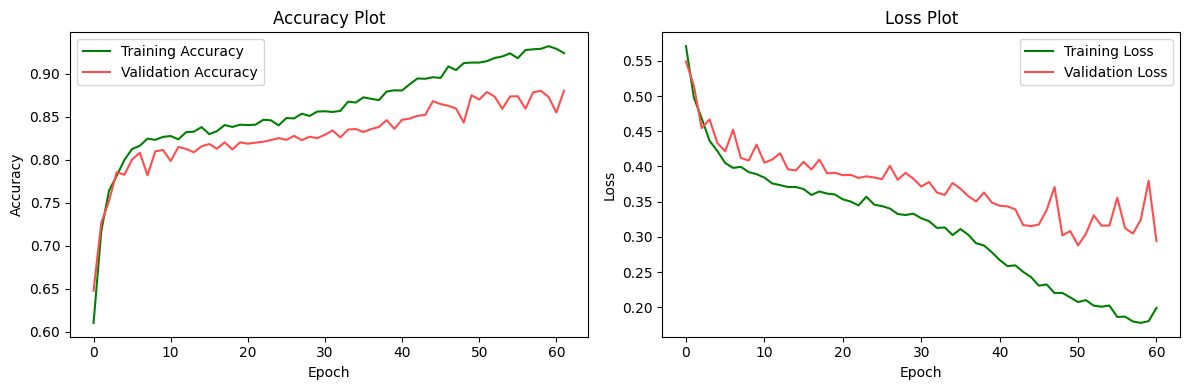

In [3]:
from backend.src.visualization.visualizing_service import plot_model_accuracy
plot_model_accuracy(history)